# Import the data




https://github.com/xc2303/MLProjects.git

In [2]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

     |████████████████████████████████| 22.2MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data=pd.read_csv("worldhappiness2019.csv")

data.head()

,Happiness_level,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region
0,Very High,Finland,1.340,1.587,0.986,0.596,0.153,0.393,Finland,Europe,Northern Europe
1,Very High,Denmark,1.383,1.573,0.996,0.592,0.252,0.410,Denmark,Europe,Northern Europe
2,Very High,Norway,1.488,1.582,1.028,0.603,0.271,0.341,Norway,Europe,Northern Europe
3,Very High,Iceland,1.380,1.624,1.026,0.591,0.354,0.118,Iceland,Europe,Northern Europe
4,Very High,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe


In [4]:
# drop some columns
data = data.drop(columns=['name', 'Country or region', 'region', 'sub-region'])
data.head()

,Happiness_level,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Very High,1.340,1.587,0.986,0.596,0.153,0.393
1,Very High,1.383,1.573,0.996,0.592,0.252,0.410
2,Very High,1.488,1.582,1.028,0.603,0.271,0.341
3,Very High,1.380,1.624,1.026,0.591,0.354,0.118
4,Very High,1.396,1.522,0.999,0.557,0.322,0.298


#  Explore bivariate relationship

In [5]:
# numerically encode target variable
target_mapping = {"Very Low": 0, "Low": 1, "Average": 2, "High": 3, "Very High": 4}
reverse_target_mapping = {value:key for (key, value) in target_mapping.items()}
data.loc[:, 'Happiness_level'] = data['Happiness_level'].replace(target_mapping)

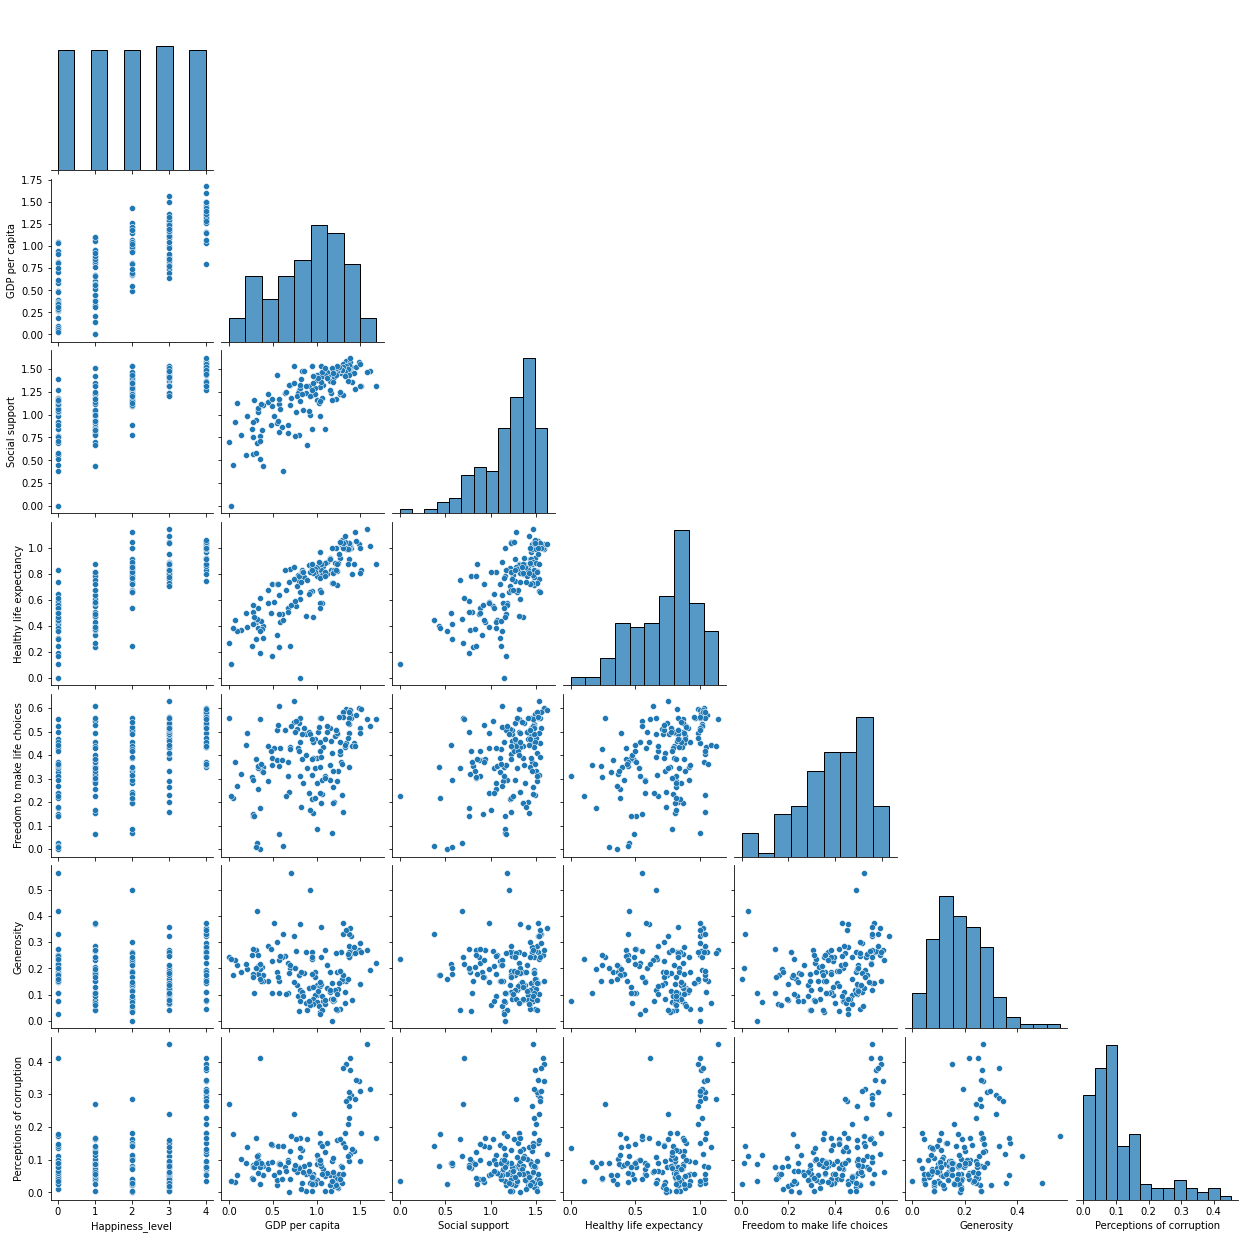

In [6]:
import seaborn as sns

sns.pairplot(data, corner=True);

Describe any relationships you see between particular features and the target variable

# Examine features that predict happiness categories using one or more models that allow for automatic feature selection

Use a recursive feature selection with cross validation to automatically select best features from a linear regression model, and examine them

In [7]:
# split into features and target
X = data.drop(columns=['Happiness_level'])
y = data['Happiness_level']

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV


# get best features from recursive feature elimination
linreg = LinearRegression()
selector = RFECV(linreg, scoring='neg_mean_absolute_error')
selector.fit(X, y)

# keep only best features
X = X[X.columns[selector.support_]]

# fit model with these features
linreg.fit(X, y)

# coeffienct describing linear relationship between features and target Happiness_level
pd.DataFrame({'feature': X.columns.values, 'coefficient': linreg.coef_}).sort_values(by='coefficient')

,feature,coefficient
4,Perceptions of corruption,0.325645
1,Social support,0.934637
0,GDP per capita,1.065305
2,Healthy life expectancy,1.834553
3,Freedom to make life choices,1.890542


# Preprocessing

In [9]:
# Set up training and test data
from sklearn.model_selection import train_test_split

# read in original data again
data=pd.read_csv("worldhappiness2019.csv")

data.head()

,Happiness_level,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region
0,Very High,Finland,1.340,1.587,0.986,0.596,0.153,0.393,Finland,Europe,Northern Europe
1,Very High,Denmark,1.383,1.573,0.996,0.592,0.252,0.410,Denmark,Europe,Northern Europe
2,Very High,Norway,1.488,1.582,1.028,0.603,0.271,0.341,Norway,Europe,Northern Europe
3,Very High,Iceland,1.380,1.624,1.026,0.591,0.354,0.118,Iceland,Europe,Northern Europe
4,Very High,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe


In [10]:
# Clean up final region data
X = data.drop(columns=['Happiness_level', 'name', 'Country or region', 'sub-region'])
y = data['Happiness_level']

X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_train.columns.tolist())

(104, 7)
(104,)
['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'region']


## Preprocess data using Column Transformer and save fit preprocessor to ".pkl" file

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [12]:
# Write function to transform data with preprocessor

def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [13]:
# Check shape for keras input:
preprocessor(X_train).shape # pretty small dataset

(104, 11)

## Create some models

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(learning_rate=.8)
xgb.fit(preprocessor(X_train), y_train)

XGBClassifier(learning_rate=0.8, objective='multi:softprob')

In [15]:
# accuracy on training data
train_acc = xgb.score(preprocessor(X_train), y_train)
test_acc = accuracy_score(xgb.predict(preprocessor(X_test)), y_test)
print(f"Train accuracy for xgboost classifier is {train_acc}")
print(f"Test accuracy for xgboost classifier is {test_acc}")

Train accuracy for xgboost classifier is 1.0
Test accuracy for xgboost classifier is 0.4230769230769231


In [16]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(preprocessor(X_train), y_train)
svc.score(preprocessor(X_train), y_train)

0.8076923076923077

In [17]:
# accuracy on training data
train_acc = svc.score(preprocessor(X_train), y_train)
test_acc = accuracy_score(svc.predict(preprocessor(X_test)), y_test)
print(f"Train accuracy for support vector classifier is {train_acc}")
print(f"Test accuracy for support vector classifier is {test_acc}")

Train accuracy for support vector classifier is 0.8076923076923077
Test accuracy for support vector classifier is 0.38461538461538464


In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)
rf.fit(preprocessor(X_train), y_train)
rf.score(preprocessor(X_test), y_test)

0.4230769230769231

In [19]:
# accuracy on training data
train_acc = rf.score(preprocessor(X_train), y_train)
test_acc = accuracy_score(rf.predict(preprocessor(X_test)), y_test)
print(f"Train accuracy for random forest classifier is {train_acc}")
print(f"Test accuracy for random forest classifier is {test_acc}")

Train accuracy for random forest classifier is 1.0
Test accuracy for random forest classifier is 0.4230769230769231


In [20]:
# XGBoost has the highest test accuracy score among all three models. Now take a look at xgboost hyperparameters
xgb

XGBClassifier(learning_rate=0.8, objective='multi:softprob')

In [21]:
# hyperparameters
colsample_bylevel=1,
colsample_bynode=1, 
colsample_bytree=1, 
gamma=0
learning_rate=0.8
max_delta_step=0
max_depth=6
min_child_weight=1
n_estimators=100
num_parallel_tree=1
reg_alpha=0
reg_lambda=1

## Save models to onnx file.  

In [22]:
#install aimodelshare and onnxmltools libraries
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 
! pip install onnxmltools --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 194kB 5.3MB/s 
     |████████████████████████████████| 4.1MB 7.8MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 9.0MB 7.0MB/s 
     |████████████████████████████████| 133kB 36.8MB/s 
     |████████████████████████████████| 7.2MB 30.4MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=0aee54e06b973c747a2afe670a2447acb469686fe4924edec09fd5e3a86d48dc
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire
ERROR: botocore 1.20.3 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 

In [23]:
#Save preprocessor function to local "preprocessor.zip" file for leaderboard submission
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

#test your preprocessor
prep=ai.import_preprocessor("preprocessor.zip")
prep(X_test)

Using TensorFlow backend.


array([[ 0.43324268,  0.98746467,  0.30608999, -0.49419308, -1.02922311,
        -1.12857011,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.22576861,  0.56985629,  0.46914502, -0.68085385, -0.47864027,
        -0.79447811,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.09373965,  1.04528737, -0.31268295, -0.4555736 ,  0.4848797 ,
        -0.8040236 ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.25170286,  0.62767899,  0.15557766,  0.70301054, -0.71460434,
        -0.202658  ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-1.36093651, -0.48058941, -1.51260074, -0.85464148, -0.08536681,
        -0.08811218,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.8906287 ,  0.89430588,  1.33877186, -0.16592757, -0.32133089,
        -0.41265869,  0.        ,  0.        ,  0.        ,  1.        ,
         0.   

In [24]:
from aimodelshare.aimsonnx import model_to_onnx
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType
from skl2onnx import update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster

# create initial_types
n = preprocessor(X_train).shape[1]
initial_type = [('float_input', FloatTensorType([None, n]))]

# need this to convert xgboost
update_registered_converter(
    XGBClassifier, 'XGBoostXGBClassifier',
    calculate_linear_classifier_output_shapes, convert_xgboost,
    options={'nocl': [True, False], 'zipmap': [True, False]})

# transform xgb model to ONNX
onnx_model_xgb = model_to_onnx(xgb, framework='sklearn', 
                               initial_types=initial_type,
                               task_type='classification')

# Save model to local .onnx file
with open("onnx_model_xgb.onnx", "wb") as f:
    f.write(onnx_model_xgb.SerializeToString())

In [25]:
#aimodelshare username and password
username = "xc2303"
password = "Columbia123"

# load submit model creds (only gives access to s3 bucket)
# Load from pkl file
import pickle
with open("aws_creds_worldhappiness.pkl", 'rb') as file:
    aws_key,aws_password,region = pickle.load(file)

token=ai.aws.get_aws_token(username, password)
awscreds=ai.aws.get_aws_client(aws_key=aws_key, aws_secret=aws_password, aws_region=region)

In [31]:
predicted_labels=xgb.predict(preprocessor(X_test))

# Submit_model() to leaderboard
ai.submit_model("onnx_model_xgb.onnx",
                "https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

True

In [32]:
import pandas
data=ai.get_leaderboard("https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=2)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,loss,optimizer,model_config,username,timestamp,version
0,0.538462,0.532364,0.593922,0.550303,sklearn,NaN,NaN,SVC,NaN,110.0,NaN,NaN,NaN,"{'C': 10, 'break_ties': False, 'cache_size': 2...",prajseth,2021-02-07 23:28:17.634985,96
1,0.538462,0.532364,0.593922,0.550303,sklearn,NaN,NaN,SVC,NaN,110.0,NaN,NaN,NaN,"{'C': 10, 'break_ties': False, 'cache_size': 2...",prajseth,2021-02-07 23:06:01.625302,94
2,0.538462,0.532364,0.593922,0.550303,sklearn,NaN,NaN,SVC,NaN,110.0,NaN,NaN,NaN,"{'C': 5, 'break_ties': False, 'cache_size': 20...",kka2120,2021-02-07 19:08:32.577228,90
3,0.538462,0.532364,0.593922,0.550303,sklearn,NaN,NaN,SVC,NaN,110.0,NaN,NaN,NaN,"{'C': 10, 'break_ties': False, 'cache_size': 2...",prajseth,2021-02-02 00:57:22.077630,67
4,0.519231,0.523419,0.567857,0.533333,keras,True,True,Sequential,4.0,35205.0,4.0,str,SGD,"{'name': 'sequential_5', 'layers': [{'class_na...",prajseth,2021-02-02 00:05:49.874938,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,NaN,NaN,NaN,NaN,keras,NaN,True,Sequential,5.0,28293.0,5.0,str,Adam,"{'name': 'sequential_26', 'layers': [{'class_n...",dv2438,2021-02-06 22:15:57.348161,80
83,NaN,NaN,NaN,NaN,sklearn,NaN,NaN,RandomForestClassifier,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",kka2120,2021-02-02 20:06:48.368529,75
84,NaN,NaN,NaN,NaN,keras,NaN,True,Sequential,5.0,28293.0,5.0,str,Adam,"{'name': 'sequential_22', 'layers': [{'class_n...",dv2438,2021-02-07 23:37:59.755178,97
85,NaN,NaN,NaN,NaN,sklearn,NaN,NaN,LinearSVC,NaN,20.0,NaN,NaN,NaN,"{'C': 87.58758758758759, 'class_weight': None,...",mro9395,2021-02-08 02:10:04.490345,98


In [33]:
ai.stylize_leaderboard(data, category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,loss,optimizer,model_config,username,version
0,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,96
1,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,94
2,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 5, 'break_ties': False, ...",kka2120,90
3,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,67
4,51.92%,52.34%,56.79%,53.33%,keras,True,True,Sequential,4.000000,35205.000000,4.000000,str,SGD,"{'name': 'sequential_5', 'laye...",prajseth,15
5,50.00%,50.50%,55.44%,51.52%,keras,True,True,Sequential,5.000000,201733.000000,5.000000,str,SGD,"{'name': 'sequential_8', 'laye...",prajseth,30
6,50.00%,50.49%,55.78%,51.48%,keras,True,True,Sequential,4.000000,135941.000000,4.000000,str,SGD,"{'name': 'sequential_9', 'laye...",prajseth,34
7,50.00%,50.22%,56.03%,51.48%,keras,True,True,Sequential,4.000000,185705.000000,4.000000,str,SGD,"{'name': 'sequential_7', 'laye...",prajseth,24
8,50.00%,50.29%,53.27%,50.65%,keras,nan,True,Sequential,5.000000,18437.000000,5.000000,str,SGD,"{'name': 'sequential_5', 'laye...",TheStreett,70
9,48.08%,47.87%,53.24%,49.55%,keras,True,True,Sequential,4.000000,35205.000000,4.000000,str,SGD,"{'name': 'sequential_10', 'lay...",prajseth,39
